<a href="https://colab.research.google.com/github/kipling123/Danger-web/blob/main/deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !unzip /content/GDGoCTel-U_can-you-spot-ai-artist.zip

In [ ]:
# !unzip -o /content/GDGoCTel-U_can-you-spot-ai-artist.zip -d /content/dataset


In [ ]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras import optimizers
from keras import applications
from keras.layers import GlobalAveragePooling2D
from keras.regularizers import l2
from keras.models import Sequential

In [ ]:
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('/content/train.csv')

train_df['label'] = train_df['label'].astype(str)

# Split dataframe menjadi training dan validation
X_train_df, X_test_df, y_train, y_test = train_test_split(
    train_df[['image']],
    train_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['label']
)

In [ ]:
train_data = pd.concat([X_train_df.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test_df.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Enhanced ImageDataGenerator configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: preprocess_input(x) * 1.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    zca_epsilon=1e-06
)


test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/content/dataset/train/",
    x_col="image",
    y_col="label",
    target_size=(100, 100),
    batch_size=32,
    class_mode="binary",
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/content/dataset/train/",
    x_col="image",
    y_col="label",
    target_size=(100, 100),
    batch_size=32,
    class_mode="binary",
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/content/dataset/test/",
    x_col="image",
    target_size=(100, 100),
    batch_size=1,
    class_mode=None,
    shuffle=False)

Found 620 validated image filenames belonging to 2 classes.
Found 155 validated image filenames belonging to 2 classes.
Found 195 validated image filenames.


In [ ]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet101V2 # Import MobileNetV2

base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Instantiate MobileNetV2
print('Loaded model!')

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Loaded model!


Model: "resnet101v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 42,626,560 (162.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,626,560 (162.61 MB)

In [ ]:
# ... (your imports and model setup) ...

# Rescale images for MobileNetV2
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # ... other augmentations you want to use ...
    validation_split=0.2  # Create a validation split
)

# Create data generators with the desired input size (224x224)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/content/dataset/train/",
    x_col="image",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/content/dataset/train/",
    x_col="image",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=42
)

# ... (Rest of model training using train_generator and val_generator ) ...

Found 620 validated image filenames belonging to 2 classes.
Found 155 validated image filenames belonging to 2 classes.


In [ ]:
top_model = base_model.output
top_model = Flatten()(top_model)

top_model = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(top_model)
top_model = Dropout(0.5)(top_model)  # Dropout 50%

top_model = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(top_model)
top_model = Dropout(0.5)(top_model)  # Dropout 50%

top_model = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(top_model)
top_model = Dropout(0.3)(top_model)  # Dropout 30%

predictions = Dense(1, activation='sigmoid')(top_model)


model = Model(inputs = base_model.input, outputs = predictions)

from tensorflow.keras.models import Model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
class_counts = train_df['label'].value_counts()
total = class_counts.sum()
class_weights = {
    0: total/(2*class_counts[0]),
    1: total/(2*class_counts[1])
}
model.fit(train_generator,
          validation_data=val_generator,
          epochs=5,
          batch_size=250)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 410s 20s/step - accuracy: 0.5299 - loss: 36.8280 - val_accuracy: 0.6645 - val_loss: 32.2773
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 420s 19s/step - accuracy: 0.6883 - loss: 32.0862 - val_accuracy: 0.7548 - val_loss: 29.7516
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 343s 17s/step - accuracy: 0.7825 - loss: 29.4995 - val_accuracy: 0.7613 - val_loss: 28.3488
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 347s 17s/step - accuracy: 0.8337 - loss: 27.8885 - val_accuracy: 0.7613 - val_loss: 27.3693
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 343s 17s/step - accuracy: 0.8552 - loss: 26.9911 - val_accuracy: 0.7548 - val_loss: 26.6504


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - accuracy: 0.9164 - loss: 29.0741 - val_accuracy: 0.7806 - val_loss: 28.5686
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.9270 - loss: 27.8934 - val_accuracy: 0.8194 - val_loss: 27.4550
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - accuracy: 0.9694 - loss: 26.7825 - val_accuracy: 0.7806 - val_loss: 26.5584
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.9416 - loss: 25.8320 - val_accuracy: 0.8000 - val_loss: 25.5514
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.9525 - loss: 24.8997 - val_accuracy: 0.7806 - val_loss: 24.7181
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.9701 - loss: 23.9920 - val_accuracy: 0.8194 - val_loss: 23.8183
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.9765 - loss: 23.1238 - val_accuracy: 0.8387 - val_loss: 23.0371
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.9912 - loss: 22.2784 - val_accura

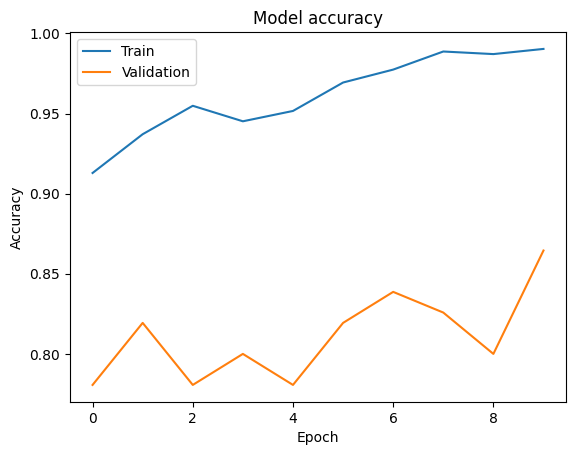

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.9970 - loss: 20.0296 - val_accuracy: 0.8452 - val_loss: 20.2104
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.9851 - loss: 19.3756 - val_accuracy: 0.8194 - val_loss: 19.5311
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9969 - loss: 18.6891 - val_accuracy: 0.8129 - val_loss: 18.9760
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9898 - loss: 18.0611 - val_accuracy: 0.8323 - val_loss: 18.3197
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9965 - loss: 17.4551 - val_accuracy: 0.8387 - val_loss: 17.7341
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.9996 - loss: 16.8835 - val_accuracy: 0.7935 - val_loss: 17.2286
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.9921 - loss: 16.3345 - val_accuracy: 0.8452 - val_loss: 16.6439
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - accuracy: 0.9996 - loss: 15.7913 - val_accuracy: 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

history = model.fit(train_generator, validation_data=val_generator, epochs=10)


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()





In [ ]:
score = model.fit(val_generator)
print('Test loss:', score.history['loss'][0])
print('Test accuracy:', score.history['accuracy'][0])

5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8421 - loss: 15.0790
Test loss: 15.218542098999023
Test accuracy: 0.8193548321723938


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="/content/dataset/test/",
    x_col="image",
    target_size=(224, 224),  # Changed target_size to (224, 224)
    batch_size=1,
    class_mode=None,
    shuffle=False
)
# Now you can use model.predict
predict = model.predict(test_generator)

Found 195 validated image filenames.
195/195 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step


In [ ]:
predict[:5]

array([[0.8253217 ],
       [0.03873786],
       [0.99759793],
       [0.08029128],
       [0.98738116]], dtype=float32)

In [ ]:
from keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array


In [ ]:
import os
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.preprocessing import image


test_df = pd.read_csv('/content/test.csv')
test_folder = "/content/dataset/test"
model = load_model('./model.h5', compile=False)

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """ Fungsi untuk memuat dan memproses gambar sebelum diprediksi """
    if not os.path.exists(img_path):
        print(f"File tidak ditemukan: {img_path}")
        return None
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

predictions = []
for img_name in test_df['image']:
    img_path = os.path.join(test_folder, img_name)
    img_array = load_and_preprocess_image(img_path)

    if img_array is None:
        predictions.append(0)
        continue

    pred = model.predict(img_array)
    pred_binary = (pred > 0.41).astype(int)
    predictions.append(pred_binary[0][0])


test_df['label'] = predictions


test_df.to_csv('submission.csv', index=False)

print("Prediksi selesai! File submission.csv telah disimpan.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113

In [ ]:
test_df

,image,label
0,777.jpg,1
1,778.jpg,0
2,779.jpeg,1
3,780.jpg,0
4,781.png,1
...,...,...
190,967.jpg,0
191,968.jpg,1
192,969.jpg,0
193,970.jpg,0


In [ ]:
test_df.to_csv("submissionRafiBaru.csv", index=False)

In [ ]:
print(model.input_shape)


(None, 224, 224, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Prediksi: Buatan_AI


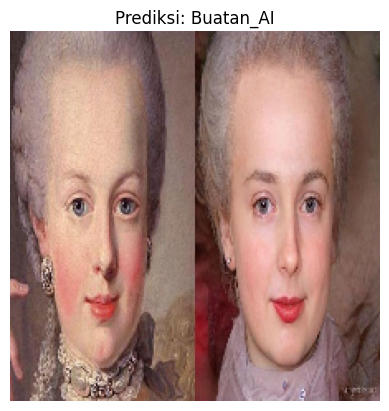

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img_path = "/content/train/10.jpg"
img = load_img(img_path, target_size=(224, 224))

img_array = img_to_array(img) / 200.0
img_array = np.expand_dims(img_array, axis=0) \

prediction = model.predict(img_array)
label = "Buatan_AI" if prediction[0] > 0.41 else "Buatan_Manusia"

print(f"Prediksi: {label}")
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {label}")
plt.show()


In [ ]:
for folder in os.listdir():
    if os.path.isdir(folder):  # Cek hanya folder
        print(f"Isi folder {folder}: ", os.listdir(folder))


Isi folder .config:  ['active_config', 'gce', 'configurations', '.last_update_check.json', 'logs', 'default_configs.db', 'hidden_gcloud_config_universe_descriptor_data_cache_configs.db', '.last_opt_in_prompt.yaml', '.last_survey_prompt.yaml', 'config_sentinel']
Isi folder .ipynb_checkpoints:  []
Isi folder drive:  ['MyDrive', '.shortcut-targets-by-id', '.file-revisions-by-id', '.Trash-0', '.Encrypted']
Isi folder test:  ['905.jpg', '961.jpg', '886.jpg', '918.jpg', '928.jpg', '844.jpg', '947.jpg', '778.jpg', '822.jpg', '959.jpg', '873.jpg', '863.jpg', '845.png', '883.jpg', '929.jpg', '900.jpg', '860.png', '917.jpg', '837.jpg', '823.jpg', '782.jpeg', '814.png', '957.jpg', '807.jpg', '869.jpg', '877.jpg', '935.jpg', '800.png', '958.jpg', '969.jpg', '941.png', '790.png', '940.jpg', '931.png', '793.jpg', '817.jpg', '933.png', '936.png', '819.jpg', '870.jpg', '859.jpg', '836.jpeg', '971.jpg', '821.jpg', '794.jpg', '866.jpg', '948.jpg', '891.jpg', '962.jpg', '787.jpg', '843.jpg', '802.jpg', '

In [ ]:
import zipfile

with zipfile.ZipFile('GDGoCTel-U_can-you-spot-ai-artist.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')  # Ekstrak ke folder dataset

print(os.listdir('dataset'))  # Cek apakah model.h5 ada di sana


['sample_submission.csv', 'train.csv', 'test', 'train', 'test.csv']


In [ ]:
import os

# Fungsi untuk mencari file model.h5
def find_model_file(start_dir='.'):
    for root, dirs, files in os.walk(start_dir):
        if 'model.h5' in files:
            return os.path.join(root, 'model.h5')
    return None

model_path = find_model_file()

if model_path:
    print(f"Model ditemukan di: {model_path}")
else:
    print("Model tidak ditemukan!")


Model ditemukan di: ./model.h5


In [ ]:
model.save('model.h5')  # Simpan model ke file
